In [1]:
import collections, itertools, re
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from nltk.tokenize import word_tokenize
import torch
from torch import nn
from skorch import NeuralNetClassifier
from gensim import downloader as api
wv = api.load('glove-twitter-50')
wv

# Data

In [2]:
Data = pd.read_csv(
    'https://drive.google.com/uc?id=1gg8CR5rojy2CemF5RGAR_iDmJeizDnu7',
    index_col='id',
)
Data

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [3]:
Data['keyword'] = Data.keyword.str.strip()
Data['location'] = Data.location.str.strip()

In [4]:
keyword_counts = Data.keyword.value_counts(dropna=False)
keyword_index = pd.Series(range(len(keyword_counts)), index=keyword_counts.index)
keyword_encoded = Data.keyword.map(keyword_index)
keyword_encoded.value_counts()

0      61
1      45
2      42
3      42
4      41
       ..
217    19
218    12
219    11
220    10
221     9
Name: keyword, Length: 222, dtype: int64

In [5]:
location_counts = Data.location.value_counts(dropna=False)
location_counts = location_counts[location_counts>=10]
location_index = pd.Series(range(len(location_counts)), index=location_counts.index)
location_encoded = Data.location.map(location_index).fillna(0).astype(int)
location_encoded.value_counts()

0     6767
1      105
2       73
3       50
4       46
5       32
6       30
7       27
8       26
9       24
10      22
11      21
12      20
13      20
15      19
14      19
16      19
17      16
19      15
18      15
20      15
21      14
22      14
24      14
23      14
25      14
28      12
26      12
29      12
27      12
33      11
32      11
30      11
31      11
39      10
36      10
38      10
34      10
40      10
37      10
35      10
Name: location, dtype: int64

In [6]:
def text_mapper(text):
    text = text.lower()
    text = word_tokenize(text)
    return wv.get_mean_vector(text)
    text = filter(wv.has_index_for, text)
    text = map(wv.get_vector, text)
    text = list(text)
    text = np.array(text)
    return text

text_encoded = Data.text.map(text_mapper)
text_encoded

id
1        [0.038688365, 0.023705168, 0.020802407, 0.0365...
4        [0.007624591, -0.052556057, -0.007742249, -0.0...
5        [0.04088558, 0.037047613, -0.021184962, 0.0039...
6        [0.049914826, 0.028075483, -0.04380075, -0.027...
7        [0.0075087794, 0.0045554917, 0.031116856, -0.0...
                               ...                        
10869    [-0.0011524583, 0.03269626, 0.0365468, -0.0183...
10870    [0.0361086, -0.0028235642, 0.04228541, -0.0118...
10871    [0.04773129, -0.030353934, -0.01209713, -0.043...
10872    [-0.032707, 0.05453244, -0.00038539694, -0.004...
10873    [0.043990437, 0.0011305993, -0.0027618525, -0....
Name: text, Length: 7613, dtype: object

In [7]:
text_encoded = pd.DataFrame(text_encoded.to_list(), index=Data.index)
text_encoded

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
id,,,,,,,,,,,,,,,,,,,,,
1,0.038688,0.023705,0.020802,0.036593,-0.013815,0.026738,0.117577,0.000807,-0.071317,0.013048,...,-0.088988,-0.021808,0.053442,-0.011665,0.004419,-0.028650,0.026631,-0.033856,0.027221,0.044898
4,0.007625,-0.052556,-0.007742,-0.088399,-0.040609,0.026169,0.015000,-0.018615,0.024686,-0.075305,...,-0.062819,-0.045381,-0.013129,0.038730,-0.004759,0.106094,0.046402,-0.011538,0.058076,0.051915
5,0.040886,0.037048,-0.021185,0.003980,-0.013771,-0.026852,0.078104,-0.015018,0.003929,-0.068713,...,-0.068392,0.044550,0.026842,-0.005203,0.042133,0.001826,0.030720,-0.001072,-0.021852,0.021322
6,0.049915,0.028075,-0.043801,-0.027892,-0.010924,-0.031094,0.070697,-0.101552,0.059769,-0.131641,...,-0.031894,-0.031512,0.025297,-0.044208,0.083225,0.024117,0.012758,-0.026127,-0.001242,0.108855
7,0.007509,0.004555,0.031117,-0.029955,-0.037021,-0.004440,0.066262,-0.052528,0.012441,-0.037497,...,-0.123948,-0.047917,-0.016931,0.012692,0.029979,0.017649,0.022200,-0.020062,-0.010173,0.052923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,-0.001152,0.032696,0.036547,-0.018391,0.022542,-0.033461,0.020918,-0.022229,0.037358,-0.095075,...,-0.070385,0.038019,-0.030048,0.002630,0.087016,0.044187,-0.001726,0.033346,0.041566,0.097049
10870,0.036109,-0.002824,0.042285,-0.011885,-0.005846,0.048861,0.086966,-0.021930,-0.030490,-0.031770,...,-0.158497,-0.008685,0.014035,0.020257,0.049675,0.058657,0.033206,0.004453,-0.016926,0.047071
10871,0.047731,-0.030354,-0.012097,-0.043127,0.000493,0.016521,0.039351,0.014129,-0.007263,0.022840,...,-0.283712,-0.030230,0.021489,0.025726,0.045143,0.032458,-0.025252,-0.098730,-0.074377,0.034559


# Model

In [8]:
X = pd.DataFrame({
    'keyword': keyword_encoded,
    'location': location_encoded,
})
X = X.astype(str)
X = pd.concat([X, text_encoded], axis=1)
X

,keyword,location,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.038688,0.023705,0.020802,0.036593,-0.013815,0.026738,0.117577,0.000807,...,-0.088988,-0.021808,0.053442,-0.011665,0.004419,-0.028650,0.026631,-0.033856,0.027221,0.044898
4,0,0,0.007625,-0.052556,-0.007742,-0.088399,-0.040609,0.026169,0.015000,-0.018615,...,-0.062819,-0.045381,-0.013129,0.038730,-0.004759,0.106094,0.046402,-0.011538,0.058076,0.051915
5,0,0,0.040886,0.037048,-0.021185,0.003980,-0.013771,-0.026852,0.078104,-0.015018,...,-0.068392,0.044550,0.026842,-0.005203,0.042133,0.001826,0.030720,-0.001072,-0.021852,0.021322
6,0,0,0.049915,0.028075,-0.043801,-0.027892,-0.010924,-0.031094,0.070697,-0.101552,...,-0.031894,-0.031512,0.025297,-0.044208,0.083225,0.024117,0.012758,-0.026127,-0.001242,0.108855
7,0,0,0.007509,0.004555,0.031117,-0.029955,-0.037021,-0.004440,0.066262,-0.052528,...,-0.123948,-0.047917,-0.016931,0.012692,0.029979,0.017649,0.022200,-0.020062,-0.010173,0.052923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10869,0,0,-0.001152,0.032696,0.036547,-0.018391,0.022542,-0.033461,0.020918,-0.022229,...,-0.070385,0.038019,-0.030048,0.002630,0.087016,0.044187,-0.001726,0.033346,0.041566,0.097049
10870,0,0,0.036109,-0.002824,0.042285,-0.011885,-0.005846,0.048861,0.086966,-0.021930,...,-0.158497,-0.008685,0.014035,0.020257,0.049675,0.058657,0.033206,0.004453,-0.016926,0.047071
10871,0,0,0.047731,-0.030354,-0.012097,-0.043127,0.000493,0.016521,0.039351,0.014129,...,-0.283712,-0.030230,0.021489,0.025726,0.045143,0.032458,-0.025252,-0.098730,-0.074377,0.034559


In [9]:
Y = Data.target
Y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
X = X.values
Y = Y.values
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((5709, 52), (1904, 52), (5709,), (1904,))

In [ ]:
grid_search = model_selection.GridSearchCV(
    estimator=linear_model.SGDClassifier(),
    param_grid={
        "alpha": (0.00001, 0.000001),
        "penalty": ("l2", "elasticnet"),
        "max_iter": (10, 50, 80),
    },
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X, Y)

In [14]:
print(metrics.classification_report(Y_train, grid_search.predict(X_train)))

              precision    recall  f1-score   support

           0       0.59      0.98      0.74      3271
           1       0.76      0.10      0.18      2438

    accuracy                           0.60      5709
   macro avg       0.68      0.54      0.46      5709
weighted avg       0.66      0.60      0.50      5709



In [15]:
print(metrics.classification_report(Y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.58      0.97      0.73      1071
           1       0.72      0.09      0.16       833

    accuracy                           0.59      1904
   macro avg       0.65      0.53      0.44      1904
weighted avg       0.64      0.59      0.48      1904



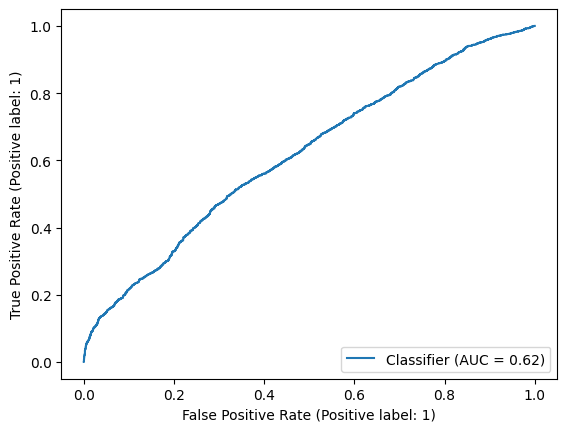

In [16]:
metrics.RocCurveDisplay.from_predictions(Y_train, grid_search.decision_function(X_train))

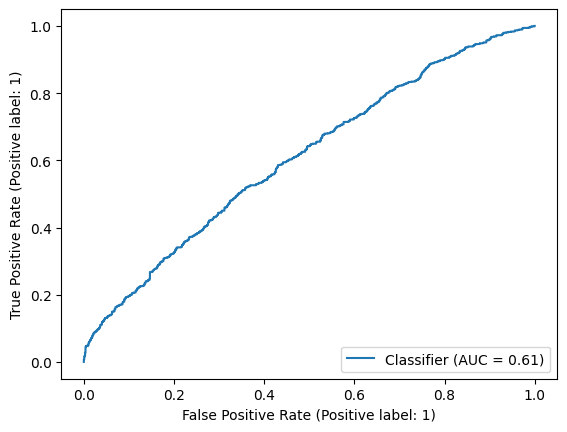

In [17]:
metrics.RocCurveDisplay.from_predictions(Y_test, grid_search.decision_function(X_test))